#**Tutorial for the Columbia HAZard (CHAZ) model** - Downscaling

---
The beta version of CHAZ can be downloaded from GitHub https://github.com/cl3225/CHAZ. This tutorial converts the scripts into JupyterNB for better understanding of each of the components.

This is the vectorized version and should run faster than `Tutorial_chaz_downscaling`

In [ ]:
# Import necessary libraries
import numpy as np
from numpy import nanmean

import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import random
from scipy.io import netcdf_file
from scipy.io import loadmat
from scipy import stats

import calendar
from datetime import datetime,timedelta
import time
import sys
import dask.array as da
import numpy.ma as ma
import gc
from netCDF4 import Dataset,date2num,num2date
import netCDF4 as nc
from dask.diagnostics import ProgressBar

## numba JIT compilation
import numba

import subprocess
import pickle
import copy


import pooch

## profiling code to look for efficiency gains
import cProfile 

from tqdm.notebook import tqdm  

from bisect import bisect_left, bisect_right




Create a random number generator from a set seed, for code testing and reproducibility. 

In [2]:
## adding random number generator with set seed to allow comparisons and reproducibility
## set seed = None to use computer chaos

seed = 42
rng = np.random.default_rng(seed=seed)

In [3]:
## added path_data to function call
def get_landmask(path_data):
    """
    This function reads landmask.nc. 
    read 0.25degree landmask.nc
    output:
        lon: longitude, 1D
        lat: latitude, 1D
        landmask: 2D

    """
    fopen = pooch.retrieve(url=f"{path_data}/landmask.nc",  known_hash=None)
    f = netcdf_file(fopen)
    lon = f.variables['lon'][:]
    lat = f.variables['lat'][:]
    landmask = f.variables['landmask'][:,:]
    f.close() ## this is not closing, see warning in [4]

    return lon, lat, landmask


## Step 0: Model basic settings

In [4]:
path_data = 'doi:10.5281/zenodo.11631930' # public data available at https://zenodo.org/records/11628647
yearTC = 2017

# Use class to define the global variables:
class gv():
    ### Experiment settings
    Model = 'ERA5'
    ENS = 'r1i1p1f1'
    TCGIinput = 'TCGI_CRH_PI'   # or "TCGI_SD_RI"
    CHAZ_ENS = 1                # Number of track realizations
    CHAZ_Int_ENS = 40           # Number of intensity realizations

    ### CHAZ parameters & other inputs path
    uBeta = -1.5
    vBeta = 2.0
    survivalrate = 0.78
    seedN = 1000                # annual seeding rate for random seeding
    obpath = 'bt_global_predictors.nc'

    llon, llat, lldmask = get_landmask(path_data)

    ldmask = lldmask[-12::-24,::24]
    lldmask = lldmask[::-1,:]

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/2435941636.py:17: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  f.close() ## this is not closing, see warning in [4]


## Step 1: Tropical Cyclogenesis

This part seed TC disturbnaces based on the TCGI fields from pre-process code

In [ ]:
def TCgiSeeding (gxlon, gxlat, gi, climInitLon, climInitLat, climInitDate, ratio, iy):
    '''
    This is a subroutine for calculating tropical cyclone genesis locations based on the
    genesis index (gi).
    
    ---- Parameters -------------------------------------- 
    gxlon : 2D array (nlat x nlon)
        mesh-grid of longitudes

    gxlat : 2D array (nlat x nlon)
        mesh-grid of latitudes
    
    gi : 3D array (month x nlat x nlon)
        Monthly tropical cyclone genisis index (gi). 
        "gi is tropical cyclone genesis index. We use nansum(gi) to for
        total number of seeds, and then randomly select location using gi
        as genesis probability."
            [higher values == more likely genisis?] TODO 
            [spatial probability distribution of cyclone 
            formation for each month.]
    
    climInitLon, climInitLat, climInitDate: lists
        Lists storing storing previous seeds information (lon, lat, and date)

    ratio: float
        how many more seeds we should give [create?], based on the survival rate
        [Scaling factor determining how many seeds to create relative to the total
        genesis index sum (accounts for survival rate).]

    iy: int
        target year for seeding

    ---- Returns ---------------------------------------- 
    None (modifies the climInitLon, climInitLat, and climInitDate lists in place)

    '''

    # loop through year (iy) by month (im) 
    for im in range(12):
        xk, pk = np.arange(gi[im,:,:].size), gi[im,:,:].ravel()

        ## remove NaNs
        dummy = xk*pk
        xk, pk = xk[dummy==dummy], pk[dummy==dummy] # (dummy==dummy is False for NaNs)

        ## Build discrete probability distribution (custm) using gi values as weights
        ## xk = possible grid indices, pk/pk.sum() = normalized probabilities
        custm = stats.rv_discrete(name='custm', values=(xk, pk/pk.sum()), seed = rng)

        ## randomly select grid point from custm 
        ## number of points selected [np.rint(pk.sum()*ratio)]
            # proportional to sum of gensis probability * ratio
        r = custm.rvs(size=np.int_(np.rint(pk.sum()*ratio)))

        ## map selected grid points into lon/lat coordinated
        iix = gxlon.ravel()[r.ravel()]
        iiy = gxlat.ravel()[r.ravel()]
        ## randomly select day in month to assign each seed 
        ## update to use set rng
        iday = rng.choice(np.arange(calendar.monthrange(iy,im+1)[1]), size=np.int_(np.rint(pk.sum()*ratio)), replace=True)

        ## if there are days assigned a seed in the month:
        if iday.size>0:
            for id in range(iday.size):
                
                x1 = np.arange(iix[id]-1,iix[id]+1.01, 0.01)
                y1 = np.arange(iiy[id]-1,iiy[id]+1.01, 0.01)

                ## update to use set rng
                xx = rng.choice(x1, 1)
                yy = rng.choice(y1, 1)

                # append generated seed information to appropriate lists
                climInitDate.append(datetime(iy,im+1,iday[id]+1,0,0))
                climInitLon.append(xx)
                climInitLat.append(yy)

    return climInitLon, climInitLat, climInitDate

## added path_data as an input to this function
def getSeeding(iy, ratio, path_data):
    '''
    TODO: ADD 
    '''
    climInitLon = []
    climInitLat = []
    climInitDate = []

    # Load the tropical cyclone genesis index (TCGI)
    tcgiFile = pooch.retrieve(url=f"{path_data}/{gv.TCGIinput}_{iy:04d}.nc", known_hash=None)
    ds = xr.open_dataset(tcgiFile)
    gi = ds.TCGI.values

    # Load longitude and latitude data
    xlon = ds['lon']
    xlat = ds['lat']

    # Create a meshgrid of longitude and latitude
    gxlon,gxlat = np.meshgrid(xlon,xlat)

    # Generate seeds based on the genesis index
    climInitLon,climInitLat,climInitDate = \
        TCgiSeeding (gxlon,gxlat,gi,climInitLon,climInitLat,climInitDate,ratio,iy)

    # Convert lists to numpy arrays and flatten them
    climInitDate = np.array(climInitDate).ravel()
    climInitLon = np.array(climInitLon).ravel()
    climInitLat = np.array(climInitLat).ravel()

    return climInitDate, climInitLon, climInitLat

In [6]:
ratio = 1 # ratio is a form of corretion in case the global TCGI number is too low
climInitDate, climInitLon, climInitLat = getSeeding(yearTC, ratio, path_data)

(-40.0, 40.0)

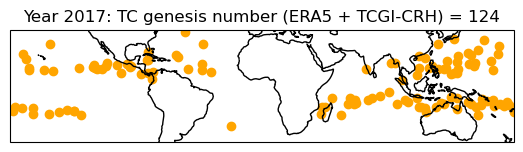

In [7]:
# Plot to see TC gensis locations:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)

ima = plt.scatter(climInitLon, climInitLat, transform=ccrs.PlateCarree(), c = 'orange', zorder=0)

plt.title(f'Year {yearTC}: TC genesis number (ERA5 + TCGI-CRH) = {len(climInitLon)}')
plt.ylim(-40, 40)

Plot genesis days

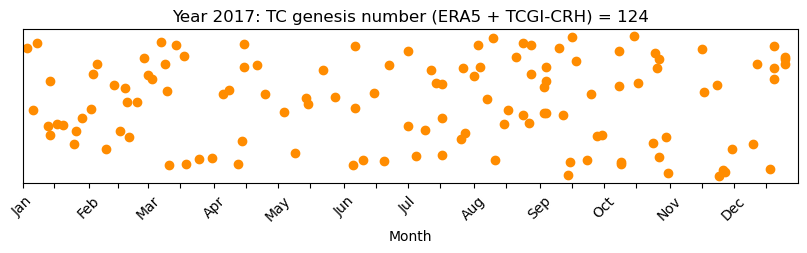

In [8]:
dates = pd.to_datetime(climInitDate)

# Extract day-of-year (1-365) for x-axis
days = dates.dayofyear

# Add a small random vertical offset so overlapping dots are visible
#y = np.random.rand(len(days)) * 0.1 + 0.5  # all dots roughly in the middle
y = rng.random(len(days)) * 0.1 + 0.5

# Plot
plt.figure(figsize=(10, 2))
plt.scatter(days, y, marker='o', color='darkorange')
plt.yticks([])  # hide y-axis

# Create x-axis ticks: start and middle of each month
tick_positions = []
tick_labels = []

for month in range(1, 13):
    start_day = datetime(2017, month, 1).timetuple().tm_yday
    mid_day = start_day + calendar.monthrange(2017, month)[1] // 2
    tick_positions.extend([start_day, mid_day])
    tick_labels.extend([calendar.month_abbr[month], ''])

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel('Month')
#plt.title('TC Seed Dates in 2017')
plt.title(f'Year {yearTC}: TC genesis number (ERA5 + TCGI-CRH) = {len(climInitDate)}')

plt.xlim(1, 365)
plt.show()


## Step 2: Tracks
This part moves the initial seeds forward using a beta-advection model. 

In [9]:
from functools import lru_cache

### helper functions to load datasets a single time and 
### hold in memory, rather than importing multiple times in loop 

@lru_cache(maxsize=None)
def load_I_MLR(year):
    '''
    TODO: ADD
    '''
    fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{year:04d}.nc", known_hash=None)
    print(f"Lazy loading from disk for year {year}")                       ## check that this only runs once 
    ds = xr.open_dataset(fileName)
    out = {k: ds[k].values for k in ['u250','v250','u850','v850']}
    lon, lat = ds['lon'].values, ds['lat'].values
    ds.close()
    return out, lon, lat

@lru_cache(maxsize=None)
def load_A(year, month):
    '''
    TODO: ADD 
    '''
    fname = pooch.retrieve(url=f"{path_data}/A_{year:04d}{month:02d}.nc", known_hash=None)
    ## check that this loads only when expected
    #print(f"\n    Loading A from disk for year {year} and month {month}")                       
    ds = xr.open_dataset(fname)
    A = ds['A'].load().values
    ds.close()
    return A

In [ ]:
def removeland(iS):
    '''
    This function removes land from the landmask.
    '''

    b = np.int_(iS.mean(keepdims=True))
    iT3 = -1

    if b<fstldmask.shape[1]:
        a = np.argwhere(fstldmask[:,b]==3).ravel()
        if a.size:
            if a.size>3:
                iT3 = a[0]+2
                fstlon[iT3:,b]=np.nan
                fstlat[iT3:,b]=np.nan
    return iT3

# ***************** CLEANED TO HERE ****************** #

## vectorized from original 
def calF(nday):
    '''
    This function finds the fourier function.
    nday: number of days
    '''
    dt = 1.0*60*60         # 1 hr in seconds
    T = np.float64(15)     # 15-day period of the fourier series
    N = 15                 # number of sine waves
    nt = np.arange(0, nday*60*60*24, dt)

    ## define iN and itt (shape/data holders)
    iN = np.arange(1, N+1, dtype = float)              ## shape (N,)
    itt = np.arange(nt.size, dtype = float)            ## shape (nt,)
    #X = np.random.uniform(0, 1, (N, 4))               ## random phases for 4 columns

    # use random number generator with set seed
    X = rng.uniform(0, 1, (4, N)).T                     ## transposed to match original shape 

    ## TODO: possible speedup w/ numba accelleration
    ##  vectorized equation
    F = (np.sqrt(2.0 / np.sum(iN**-3)) *
            np.sum(
                (iN**(-3/2))[:, None, None] * 
                np.sin(2*np.pi * ((iN[:, None, None] * itt[None, :, None]) / (24*T) + X[:, None, :])),
                axis=0
            )
    )

    return F

def date_interpolation(dateInput,fileInput):
    """
    fileInput is a 3-d gloabl fields  with time-axis on the first column, eg. fileInput[it,ix,iy]
    the function return fields interpolated linearly to date on dateInput.
    if dateInput.month is December, then it returns Dec. field
    """
    if dateInput.day >= 15:
        if dateInput.month < 12:
            date0 = datetime(dateInput.year,dateInput.month,15,0,0)
            date1 = datetime(dateInput.year,dateInput.month+1,15,0,0)
            dfdays = (dateInput-date0).days
            xp = [0, (date1-date0).days]
            ratio = np.interp(dfdays,xp,[0,1])
            fileOutput = fileInput[dateInput.month-1,:,:]*(1-ratio)+fileInput[dateInput.month,:,:]*(ratio)
        else:
            fileOutput= fileInput[dateInput.month-1,:,:]
    else:
        if dateInput.month == 1:
            fileOutput= fileInput[dateInput.month-1,:,:]
        else:
            date0 = datetime(dateInput.year,dateInput.month-1,15,0,0)
            date1 = datetime(dateInput.year,dateInput.month,15,0,0)
            dfdays = (dateInput-date0).days
            xp = [0, (date1-date0).days]
            ratio = np.interp(dfdays,xp,[0,1])
            fileOutput = fileInput[dateInput.month-2,:,:]*(1-ratio)+fileInput[dateInput.month-1,:,:]*ratio
    return fileOutput


@numba.jit(nopython = True)
def _getTrackPrediction(u250, v250, u850, v850, dt, fstLon, fstLat, uBeta, vBeta):
    fstLat_rad = fstLat*np.pi/180.
    alpha = 0.8
    uTrack = alpha*u850 + (1.-alpha)*u250 + uBeta
    vTrack = alpha*v850 + (1.-alpha)*v250 + vBeta*np.sign(np.sin(fstLat_rad))
    dx = uTrack*dt
    dy = vTrack*dt
    return dx, dy

def getTrackPrediction(u250,v250,u850,v850,dt,fstLon,fstLat,fstDate):
    '''
    This function predicts the track.
    u250: zonal wind time series at 250 hPA.
    v250: meridional wind time series at 250 hPA.
    u850: zonal wind time series at 850 hPA.
    v850: meridional wind time series at 850 hPA.
    dt: time differential.
    fstLon: longitude 
    fstLat: latitude
    fstDate: date
    '''

    #### modify Beta
    earth_rate = 7.2921150e-5              # mean earth rotation rate in radius per second
    r0 = 6371000                           # mean earth radius in m
    lat0 = np.arange(-90,100,10)
    phi0 = lat0/180.*np.pi                 # original latitude in radian (ex. at 15 degree N)
    beta0 = 2.0*earth_rate*np.cos(phi0)/r0 # per second per m
    beta0 = beta0/beta0[10]
    ratio = np.interp(fstLat,np.arange(-90,100,10),beta0)
    uBeta = gv.uBeta*ratio
    vBeta = gv.vBeta*ratio
    ################

    ## accellerating this part with numba
    # alpha = 0.8
    # uTrack = alpha*u850+(1.-alpha)*u250+uBeta
    # vTrack = alpha*v850+(1.-alpha)*v250+vBeta*np.sign(np.sin(fstLat*np.pi/180.))
    # dx = uTrack*dt
    # dy = vTrack*dt
    dx, dy = _getTrackPrediction(u250, v250, u850, v850, dt, fstLon, fstLat, uBeta, vBeta)

    lon2,lat2 = getLonLatfromDistance(fstLon,fstLat,dx,dy)
    fstLon,fstLat = lon2,lat2
    fstDate += timedelta(seconds=dt)
    #print uBeta, vBeta,fstLon,fstLat

    return fstLon,fstLat,fstDate

## adding numba acceleration 
@numba.jit(nopython=True)
def getLonLatfromDistance(lonInit,latInit,dx,dy):
    '''
    This function calculates the latitude from the distance.
    lonInit: initial longitude
    latInit: initial latitude
    dx: x differential
    dy: y differential
    '''
    er = 6371000           #km
    londis = 2*np.pi*er*np.cos(latInit/180*np.pi)/360.
    lon2 = lonInit+dx/londis
    latdis = 2*np.pi*er/360.
    lat2 = latInit+dy/latdis
    return lon2,lat2

## possibly room to split out some of the calculations in this 
## and numba accelerate
def bam(iS,block_id=None):
    """
    Beta-Advection Model (BAM)
    Simulates the track of a tropical cyclone.

    Parameters:
    iS (array): Index of the initial condition for the simulation.
    block_id (optional): Dask block identifier.

    Returns:
    ##int: Index of the initial condition.
    """
    # [1] Generate F from Emanuel et. al. (2006). It is a Fourier series where the individual wave components have a random phase.
    neighbors=((0,1),(0,-1),(1,0),(-1,0),(1,1),(-1,1),(1,-1),(-1,-1),(0,2),(0,-2),(2,0),(-2,0)) 
    missing_value = 1e+20

    dt = 1.0*60*60
    T = np.float64(15)      # 15-day period of the fourier series (i think)
    F = calF(15)            # computer fourier series 
    #print(F)
    nt = np.arange(0,T*60*60*24,dt)
    b = np.int_(iS.mean(keepdims=True)[0])
    #b = iS

    #initialize start position/date
    fstDate = climInitDate[b]
    fstLon = climInitLon[b]
    fstLat = climInitLat[b]
    fstlon[0,b] = fstLon
    fstlat[0,b] = fstLat
    fstldmask[0,b] = 0

    endhours = fstlon.shape[0]-1
    endDate = climInitDate[b] + timedelta(hours = endhours)
    count,year0,month0,day0 = 1,0,0,0

    ## Update
    ## used cache loading function
    A_matrix = load_A(fstDate.year, fstDate.month)
    month0 = fstDate.month
 
    while fstDate < endDate and fstDate.year==yearTC:

        if fstDate.year != year0:
            ## load dataset cached once and reference 
            year_data, xlong, xlat = load_I_MLR(fstDate.year)
            u250m = year_data['u250']
            u850m = year_data['u850']
            v250m = year_data['v250']
            v850m = year_data['v850']
            
            xxlong,xxlat = np.meshgrid(xlong,xlat)
            #ds.close()
            year0 = fstDate.year

        if fstDate.day != day0:
            #print fstDate.day,day0
            u250m2d = date_interpolation(fstDate,u250m)
            v250m2d = date_interpolation(fstDate,v250m)
            u850m2d = date_interpolation(fstDate,u850m)
            v850m2d = date_interpolation(fstDate,v850m)
            day0=fstDate.day

        ## updated to chache loading -- this saves a lot of time 
        ## because dataset was fully loaded into memory for each date
        if (fstDate.month != month0):
            A_matrix = load_A(fstDate.year, fstDate.month)
            # FileAName = pooch.retrieve(url=f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc",  known_hash=None)
            # dsA = xr.open_dataset(FileAName)
            # A_matrix = dsA.variables['A'].load()
            # dsA.close()
            month0 = fstDate.month
        A = A_matrix[:,fstDate.day-1,:,:]
        day0 = fstDate.day

        ## unchanged
        distance = np.sqrt((fstLon-xxlong)**2+(fstLat-xxlat)**2)
        iy,ix = np.unravel_index(np.argmin(distance),distance.shape)
        iy1,ix1 = np.max([iy-2,0]),np.max([ix-2,0])
        iy2,ix2 = np.min([iy+2,distance.shape[0]]),np.min([ix+2,distance.shape[1]])

        iit = np.mod(count,nt.shape[0])
        u250 = u250m2d[iy1:iy2+1,ix1:ix2+1]+A[0,iy1:iy2+1,ix1:ix2+1]*F[iit,0]
        v250 = v250m2d[iy1:iy2+1,ix1:ix2+1]+A[1,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+A[2,iy1:iy2+1,ix1:ix2+1]*F[iit,1]
        u850 = u850m2d[iy1:iy2+1,ix1:ix2+1]+A[3,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+\
                         A[4,iy1:iy2+1,ix1:ix2+1]*F[iit,1]+A[5,iy1:iy2+1,ix1:ix2+1]*F[iit,2]
        v850 = v850m2d[iy1:iy2+1,ix1:ix2+1]+A[6,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+\
                         A[7,iy1:iy2+1,ix1:ix2+1]*F[iit,1]+A[8,iy1:iy2+1,ix1:ix2+1]*F[iit,2]+\
                         A[9,iy1:iy2+1,ix1:ix2+1]*F[iit,3]


        u250 = np.nanmean(u250)
        u850 = np.nanmean(u850)
        v250 = np.nanmean(v250)
        v850 = np.nanmean(v850)

        fstLon, fstLat, fstDate = getTrackPrediction(u250,v250,u850,v850,dt,fstLon,fstLat,fstDate)
        #print fstDate,year0,day0
        if ((fstLon<0.0) or (fstLon>360) or (fstLat<-60) or (fstLat>60)):
            #print b, 'break for going to the space'
            break
        fstlon[count,b] = fstLon
        fstlat[count,b] = fstLat
        fstldmask[count,b] = np.rint(np.nanmean(gv.ldmask[iy1:iy2+1,ix1:ix2+1]))
        
        count += 1

    return b

def getBam(cDate,cLon,cLat,iy,ichaz):
    '''
    This function creats a beta-advection model object.
    cDate: (ndarray) date
    cLon: (ndarray) longitude
    cLat: latitude
    iy: (int) year in CHAZ iteration
    ichaz: (int) ensemble in CHAZ iteration
    exp: (str) directory name containing historical and future simulations 
    ''' 
    global climInitDate,climInitLon,climInitLat
    climInitDate,climInitLon,climInitLat = cDate,cLon,cLat
    nnt = np.int_(31)                                         # longest track time
    nS = climInitLon.shape[0]

    global fstlon, fstlat, fstldmask
    fstlon = np.zeros([nnt*24+1,nS])*np.nan
    fstlat = np.zeros([nnt*24+1,nS])*np.nan
    fstldmask = np.zeros(fstlat.shape)
    diS = da.from_array(np.arange(0,nS,1).astype(dtype=np.int32),chunks=(1,))
    niS = np.arange(0,nS,1).astype(dtype=np.int32)
    new = da.map_blocks(bam, diS, chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    b = new.compute(scheduler='synchronous', num_workers=5)
    

    print('removeland')

    #sys.exit()
    fstlon = fstlon[::6,:]
    fstlat = fstlat[::6,:]
    fstldmask = fstldmask[::6,:]
    #for iS in niS:
    #    c = removeland(np.array([iS,iS]))
    new = da.map_blocks(removeland,diS,chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    c = new.compute(scheduler='synchronous',num_workers=5)
    
    print('give times')
    ### give times
    # TODO - area for speedup
    fsttime = np.empty(fstlon.shape, dtype=object)
    fsttime[0,:] = climInitDate
    dummy = pd.DataFrame(fstlon)
    #import pdb;pdb.set_trace()

    ## i think .apply is a bottleneck
    # iT1 = np.int16(dummy.apply(func_first,axis=0))+1
    # iT2 = np.int16(dummy.apply(func_last,axis=0))

    ## vectorize/remove .apply
    ## but this doesn't seem to be
    ## that much quicker 
    mask = dummy.notna()
    iT1 = np.int16(mask.idxmax(axis=0)) + 1
    iT2 = np.int16(mask[::-1].idxmax(axis=0))
    # Handle all-NaN columns
    iT1[~mask.any(axis=0)] = 0
    iT2[~mask.any(axis=0)] = 0

    ## original 
    for iS in niS:
        fsttime[iT1[iS]:iT2[iS]+1,iS] = \
        [climInitDate[iS]+timedelta(hours=6*iit) for iit in range(iT1[iS],iT2[iS]+1,1)]
            
        ## tried moving this outside of the loop, 
        ## because i thought it only needed to happen once
        ## but it changed intensity of tracks    
        fst = {'lon':fstlon,
                'lat':fstlat,
                'Time':fsttime,
                'ldmask':fstldmask}

    return fst

    
## get predictors:
class fst2bt(object):
    """
    This converts data format from fst to format of bt object.
    """
    def __init__(self,data):
        self.StormId = np.arange(0,data['lon'].shape[1],1)
        self.StormYear = []
        self.StormInitMonth = []
       
        ## original
        for iS in self.StormId:
            if data['Time'][0,iS] is not None:
                self.StormYear.append(data['Time'][0,iS].year)
                self.StormInitMonth.append(data['Time'][0,iS].month)
            else:
                self.StormYear.append(1800)
                self.StormInitMonth.append(1)
        
        
        self.StormYear = np.array(self.StormYear)
        self.StormInitMonth = np.array(self.StormInitMonth)
        
        
        for iS in range(data['Time'].shape[1]):
            data['Time'][:,iS] = np.array([datetime(1800,1,1,0) if v is None else v for v in data['Time'][:,iS]])
        
        
        data['Time'][data['lon']!=data['lon']] = datetime(1800,1,1,0)
        data['lon'][data['Time']==datetime(1800,1,1,0)] = np.float64('Nan')
        self.StormLon = data['lon']
        self.StormLat = data['lat']
        self.Time = data['Time']
        self.PIwspd = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIslp = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIwspdMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dPIwspd = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIslpMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.UShearMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.UShear = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.VShearMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.VShear = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.div200Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.div200 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T200Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T200 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh500_300Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh500_300 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rhMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T100Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T100 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaE = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEs = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEsMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.landmask = data['ldmask']
        self.landmaskMean = data['ldmask']
        self.trSpeed = np.zeros(data['lon'].shape)*np.float64('Nan')
        self.trDir = np.zeros(data['lon'].shape)*np.float64('Nan')
        self.dVdt = np.zeros(data['lon'].shape)

def getSpeedDir(iiS,block_id=None):
    '''
    This function finds the speed and direction of the storm based on [TODO: based on what?]
    '''
    ## iS is defined twice (can this be avoided?)
    iS = np.int_(iiS.mean(keepdims=True)[0])
    if (bt.StormLat[:,iS]==bt.StormLat[:,iS]).any():
        it1 = np.argwhere(bt.StormLat[:,iS]==bt.StormLat[:,iS])[0,0]
        it2 = np.argwhere(bt.StormLat[:,iS]==bt.StormLat[:,iS])[-1,0]
        if it2 - it1 >=2:
            bt.trDir[it1:it2,iS],bt.trSpeed[it1:it2,iS]=\
                getStormTranslation(bt.StormLon[it1:it2,iS],\
            bt.StormLat[it1:it2,iS],bt.Time[it1:it2,iS])
    return iS

def getStormTranslation(lon,lat,time):
    '''
    This function find the storm speed and direction.
    lon: longitude
    lat: latitude
    time: time
    sdir: (ndarray) storm direction
    speed: (ndarray) speed
    '''

    ## vectorizing this saves ~1 second on my machine
    ## but it isn't working so removed for now
    ## probably still space for speedups here

    er = 6371.0 #km
    timeInt = []
    lonInt = []
    latInt = []

    for iN in range(time.shape[0]-1):
        timeInt.append(time[iN])
        lonInt.append(lon[iN])
        latInt.append(lat[iN])
        delt = 6
        inv = 1./np.float64(delt)
        for iM in range(1, delt, 1):
            timeInt.append(time[iN]+timedelta(hours=iM))
            lonInt.append((1.-iM*inv)*lon[iN]+iM*inv*lon[iN+1])
            latInt.append((1.-iM*inv)*lat[iN]+iM*inv*lat[iN+1])
    
    timeInt.append(time[-1])
    lonInt.append(lon[-1])
    latInt.append(lat[-1])
    
    ## convert to arrays for vectorization
    timeInt = np.array(timeInt)
    lonInt = np.array(lonInt)
    latInt = np.array(latInt)
    
    ## vectorized 
    nup = np.array([np.argmin(np.abs(timeInt - (t + timedelta(hours=3)))) for t in time])
    ndn = np.array([np.argmin(np.abs(timeInt - (t - timedelta(hours=3)))) for t in time])
    
    londis = 2*np.pi*er*np.cos(latInt[nup]/180*np.pi)/360
    dx = londis * (lonInt[nup] - lonInt[ndn])
    dy = 110 * (latInt[nup] - latInt[ndn])
    distance = np.sqrt(dx*dx + dy*dy)  # km
    
    sdir = np.arctan2(latInt[nup] - latInt[ndn], lonInt[nup] - lonInt[ndn])
    speed = distance*1000 / (nup - ndn + 1) / 60 / 60  # m/s using actual index difference
    
    return sdir, speed


def argminDatetime(time0,time):
    """
    Returns the index of datetime array time for which
    the datetime time0 is nearest.
    """

    # compute the absolute differences between time0 and all elements in time, 
    # then find the index of the minimum
    ##  vectorized
    time = np.array(time)
    return np.argmin(np.abs(time - time0))

def get_predictors(iiS,block_id=None):
    '''
    This function returns an object containing the predictors.
    '''

    ## iS is defined multiple times across many functions (can this be avoided?)
    iS = np.int_(iiS.mean(keepdims=True)[0])
    
    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']

    if bt.StormYear[iS]==yearTC:
        fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{bt.StormYear[iS]:04d}.nc",  known_hash=None)
        ds = xr.open_dataset(fileName)
        xlong = ds['lon'].values
        xlat = ds['lat'].values
        PIVmax = ds['PI'].values * 1.94384449 #m/s - kt
        u250 = ds['u250'].values
        u850 = ds['u850'].values
        v250 = ds['v250'].values
        v850 = ds['v850'].values
        u = u250-u850
        v = v250-v850
        meanrh = ds['hur'].values
        xxlong,xxlat = np.meshgrid(xlong,xlat)
        del xlong, xlat
        ds.close()

        ## Precompute outside of the loop, since these are constant
        er = 6371.0 #km
        londis = 2*np.pi*er*np.cos(xxlat/180*np.pi)/360
        distance = np.empty(xxlong.shape,dtype=float)       ## moved outside loop, don't think it needs to be recalculated each time 
                
        for it in range(0,bt.StormLon[:,iS].shape[0],1):
            if bt.Time[it,iS] != datetime(1800,1,1,0):

                dx = londis*(xxlong - bt.StormLon[it,iS])
                dy = 110 * (xxlat - bt.StormLat[it,iS])
                distance = np.sqrt(dx*dx+dy*dy)
                (j0,i0) = np.unravel_index(np.argmin(distance),distance.shape)

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],PIVmax),0,500
                bt.PIwspdMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.PIwspd[it,iS] = var[j0,i0]

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],u),200,800
                bt.UShearMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.UShear[it,iS] = var[j0,i0]

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],v),200,800
                bt.VShearMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.VShear[it,iS] = var[j0,i0]

                var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],meanrh),200,800
                bt.rhMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.rh[it,iS] = var[j0,i0]

                var,radius1,radius2 = copy.copy(gv.ldmask),0,300
                var[var==0] = -1.
                var[var==3] = 0.0
                bt.landmaskMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
                bt.landmask[it,iS] = var[j0,i0]

    return iS

def calPredictors(fst,iy,ichaz):
    '''
    This function creates the 'trackPredictorsbt' pickle file.
    fst: object
    iy: (int) year in CHAZ.py iteration
    ichaz: (int) ensemble in CHAZ.py iteration
    exp: (str) directory containing historical or future simulations
    '''

    global bt
    time1 = time.time()
    bt = fst2bt(fst)
    nS = fst['lon'].shape[1]
    #diS = da.from_array(np.int32(np.arange(0,nS,1)),chunks=(1,))
    #niS = np.int32(np.arange(0,nS,1))
    diS = da.from_array(np.arange(0,nS,1).astype(dtype=np.int32),chunks=(1,))
    niS = np.arange(0,nS,1).astype(dtype=np.int32)
    new = da.map_blocks(getSpeedDir,diS,chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    new.compute(scheduler='synchronous',num_workers=5)
    print('done translation speed', time.time()-time1)
    del new
    #gc.collect()

    time1 = time.time()
    new = da.map_blocks(get_predictors,diS,chunks=(1,), dtype=diS.dtype)
    #with ProgressBar():
    a = new.compute(scheduler='synchronous',num_workers=5)
    print(' done calPredictors', time.time()-time1)
    gc.collect()

    with open(f'trackPredictorsbt{iy:04d}_ens{ichaz:03d}.pik','wb+')as f:
        pickle.dump(bt,f)
    f.close()

It takes a while to run for the first due to downloading A data. The  real run-time should be roughly 3 minutes per year of tracks (i.e. when you ran on your own machine, if should be faster).



In [11]:
%%time
# Loop to generate n_syn_track of realization of synthetic TC tracks:
n_syn_track = gv.CHAZ_ENS

for ichaz in range(1, n_syn_track+1):
  # [1] Get realization i of TC tracks:
  #      each realization will be saved at the current working folder as "track_yi_ens_ichaz.pik'
  fst = getBam(climInitDate, climInitLon, climInitLat, yearTC, ichaz)

  # [2] Get the predictors along TC tracks, and saved the predictors as 'trackPredictorsbtyear_ensMember.pik' for downscaling TC intensity in the next step:
  calPredictors(fst, yearTC, ichaz)

  with open(str(yearTC)+'_track.pik','wb+')as f:
    pickle.dump(fst,f)
    f.close()
'''
with open(str(yearTC)+'_track.pik','rb') as f:
  fst = pickle.load(f)
  f.close()

with open(f'trackPredictorsbt{yearTC:04d}_ens001.pik','rb') as f:
  bt = pickle.load(f)
  f.close()
'''

Lazy loading from disk for year 2017
removeland
give times
done translation speed 0.6195011138916016
 done calPredictors 4.348556995391846
CPU times: user 16.6 s, sys: 1.12 s, total: 17.8 s
Wall time: 17.9 s


"\nwith open(str(yearTC)+'_track.pik','rb') as f:\n  fst = pickle.load(f)\n  f.close()\n\nwith open(f'trackPredictorsbt{yearTC:04d}_ens001.pik','rb') as f:\n  bt = pickle.load(f)\n  f.close()\n"

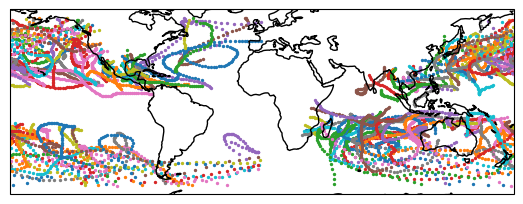

In [12]:
# Plot the last realization of syntheric TC tracks (one year):

## probably don't need to import these twice
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)

for i, longen in enumerate(climInitLon):
    lat, lon = fst['lat'][:, i], fst['lon'][:, i]
    plt.scatter(lon, lat, s=2, transform=ccrs.PlateCarree())


## Step 3: Mean and Standard deviation of all the predictors
To calculate the mean and standard deviation of the predictors, we need to apply observed tracks over model fields for the period of 1980-2012 using getMeanStd.py. It is a single stand-alone script, so we are not running it here but providing you with the output: result_w.nc and results_l.nc.

## Step 4: Intensity

Using tracks and predictors calculated from Step 2, and predictors' mean and standard deviation from 'getMeanStd.py', we are now calculate storm intensity

### Non-vectorized, but somewhat optimized version (that matches frozen original in output)

commented out, but in theory shuld be able to have both this and the vectorized version uncommented and having things work.
however, this code is a mess, so that might not be the case

### Attempt at vectorization

Trying to: 
- process all storms simultaneously at each time step to remove per-storm loops 
- remove dask overhead
- hopefully speed things up

Still need to: 
- get randomization back in here and working


In [13]:
class Processor():
    """Class container for processing stuff."""

    _counter = 0

    def addcounter(self):
        """Increment the counter."""
        # Some code here ...
        self._counter += 1

proc = Processor()

In [14]:

### same as previous
def get_E1(bt):
    """
    get errors and residual of errors from predictand bt
    return:
      errors(E1), 
      [v0E],
      ranges of v0 (cat1)
    """

    NS = np.where((bt['StormYear']>=1981)&(bt['StormYear']<=2012))[0]

    data  = bt['errors'][:, NS].values          # shape (T, N)
    data2 = bt['StormMwspd'][:, NS].values      # shape (T, N)

    data1 = data.ravel(order = 'F')
    data4 = data2.ravel(order = 'F')

    ## mask out NaNs in data1
    nan_mask = ~np.isnan(data1)

    E1  = data1[nan_mask]
    E0  = data1[nan_mask]      
    v0E = data4[nan_mask]

    E2 = E0 * E1 * v0E
    mask = (E2 == E2)
    E0 = E0[mask]
    E1 = E1[mask]
    v0E = v0E[mask]
    c11, c0 = np.polyfit(E0, E1, 1)

    vals = v0E
    vmin = vals.min()
    vmax = vals.max()

    ## threshold grids 
    grid_up = np.arange(vmin, vmax, 10)       # for c1 (min → max)
    grid_dn = np.arange(vmax, vmin, -10)      # for c2 (max → min)

    ### c1 
    ## for every threshold iC in grid_up, compute how many values satisfy v0E < iC
    ## (n_vals,1) < (1,n_thresholds)
    counts_lt = (vals[:, None] < grid_up[None, :]).sum(axis=0)

    ## Pick first threshold where count > 50
    idx = np.argmax(counts_lt > 50) if np.any(counts_lt > 50) else len(grid_up)-1
    c1 = grid_up[idx]

    ### c2 
    # for every threshold iC in grid_dn, compute how many values satisfy v0E > iC
    counts_gt = (vals[:, None] > grid_dn[None, :]).sum(axis=0)

    idx = np.argmax(counts_gt > 50) if np.any(counts_gt > 50) else len(grid_dn)-1
    c2 = grid_dn[idx]

    ## final range
    cat1 = np.arange(c1, c2 + 10, 10)

    return E0,v0E,cat1


random_call_log_vec = []

#def findError_vectorized(errort, v0E, v0_array, cat1):

## added inputs for local rng generation
def findError_vectorized(errort, v0E, v0_array, cat1, storm_ids, time_step, ensemble_member):
    '''
    Calculate error for multiple storms
    '''
    nStorms = v0_array.shape[0]
    result = np.zeros(nStorms)
    
    for iS in range(nStorms):
        ## LOCAL ERROR
        storm_id = storm_ids[iS]

        v0 = v0_array[iS]
        if np.isnan(v0):
            result[iS] = 0
        else:
            if v0 <= cat1[0]:
                mask = v0E < cat1[1]
            elif v0 >= cat1[-1]:
                mask = v0E >= cat1[-1]
            else:
                # find using searchsorted (faster than find_range)
                j0 = np.searchsorted(cat1, v0, side='right') - 1
                mask = (v0E >= cat1[j0]) & (v0E < cat1[j0+1])
            
            error1 = errort[mask]
            ## TODO: FREEZING RANDOM
            #result[iS] = error1[0] if len(error1) > 0 else 0
            
            ## i think this i how to add back in error? 
            #result[iS] = rng.choice(error1) if len(error1) > 0 else 0
            #result[iS] = rng_error.choice(error1) if len(error1) > 0 else 0

            ## LOCAL ERROR
            local_seed = seed + ensemble_member * 1000000 + storm_id * 10000 + time_step * 10

            ## debugging
            random_call_log_vec.append((ensemble_member, storm_id, time_step, local_seed))

            ## trying to match number of error calls 
            # if len(error1) > 0:
            #     local_rng = np.random.default_rng(seed=local_seed)
            #     result[iS] = local_rng.choice(error1)
            #     proc.addcounter()
            
            # else:
            #     result[iS] = 0
            
            local_rng = np.random.default_rng(seed=local_seed)
            result[iS] = local_rng.choice(error1) if len(error1) > 0 else 0

            proc.addcounter()

    return result

## trying to numba speedup getPrediction
## doesn't improve efficiency very much, but doesn't slow it down, still tinkering
## TODO: not currently using _compute_shrd

@numba.jit(nopython=True, cache=True)
def _compute_shrd(UShear, VShear):
    """Compute shear magnitude"""
    return np.sqrt(UShear**2 + VShear**2)

@numba.jit(nopython=True, cache=True)
def _normalize_and_accumulate(rvar, meanX_val, stdX_val, result_val, dy):
    """Normalize variable and add to accumulator"""
    rvar_norm = (rvar - meanX_val) / stdX_val
    return dy + rvar_norm * result_val

def getPrediction_v0input_result_vectorized(bt, meanX, meanY, stdX, stdY, it,
                                           storm_indices, fstperiod, result, predictors,
                                           TimeDepends, v0_array, dvdt_array):

    nStorms = len(storm_indices)
    ih = fstperiod[0]
    lT = int(ih/6)
    
    dy_array = np.full(nStorms, result[0])
    
    ## precompute piwspd_mean for all storms
    piwspd_slices = bt.PIwspdMean[it:it+lT+1, storm_indices]
    piwspd_mean_array = np.nanmean(piwspd_slices, axis=0)
    
    count2 = 0
    for var in predictors:
        if var == 'SHRD':
            ## SHRD calc for all storms (see if numba still works)
            ushear = bt.UShearMean[it:it+lT+1, storm_indices]
            vshear = bt.VShearMean[it:it+lT+1, storm_indices]
            shrd_vals = np.sqrt(ushear**2 + vshear**2)
            rvar_array = np.nanmean(shrd_vals, axis=0)
        elif var == 'dPIwspd':
            rvar_array = piwspd_mean_array - v0_array
        elif var in TimeDepends:
            rvar_array = np.nanmean(getattr(bt, var)[it:it+lT+1, storm_indices], axis=0)
        elif var == 'StormMwspd':
            rvar_array = v0_array
        elif var == 'dVdt':
            rvar_array = dvdt_array
        elif var == 'landmaskMean':
            rvar_array = getattr(bt, var)[it+lT+1, storm_indices] - getattr(bt, var)[it, storm_indices]
        elif var == 'StormMwspd2':
            rvar_array = (getattr(bt, 'StormMwspd')[it, storm_indices])**2
        elif var == 'StormMwspd3':
            rvar_array = (getattr(bt, 'StormMwspd')[it, storm_indices])**3
        elif var == 'MPI':
            rvar_array = piwspd_mean_array
        elif var == 'MPI2':
            rvar_array = piwspd_mean_array**2
        elif var == 'dPIwspd2':
            rvar_array = (piwspd_mean_array - v0_array)**2
        elif var == 'dPIwspd3':
            rvar_array = (piwspd_mean_array - v0_array)**3
        elif var == 'dVdt2':
            rvar_array = dvdt_array**2
        elif var == 'dVdt3':
            rvar_array = dvdt_array**3
        else:
            rvar_array = getattr(bt, var)[it, storm_indices]
        
        ## normalize and accumulate for all storms
        dy_array = _normalize_and_accumulate(rvar_array, meanX[count2+1], 
                                            stdX[count2+1], 
                                            result[count2+1], dy_array)
        count2 = count2 + 1
    
    dy_array = (dy_array * stdY) + meanY
    v1_array = v0_array + dy_array
    
    return v1_array

def get_landmask_value(bt, it, lT, iS):
    '''
    created this to remove duplicate code in get_determin and get_stochastic
    '''

    # using a single lookup instead of two
    ## slightly faster without optimized dask
    ## not sure about all edge cases 
    landmask_it = bt.landmaskMean[it,iS]
    landmask_itlT = bt.landmaskMean[it+lT,iS]
    
    # further simplifying boolean logic
    if landmask_itlT <= -0.5 and landmask_it <= -0.5:
        return result_w, meanX_w, meanY_w, stdX_w, stdY_w, \
               ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2']
    
    ## assuming no other combination available except
    ## landmask_itlT > -0.5 and landmask_it > -0.5
    else:
        return result_l, meanX_l, meanY_l, stdX_l, stdY_l, \
               ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']


def get_determin_vectorized():
    '''
    This function finds the deterministic component of the autoregressive TC intensity model.
    '''
    nStorms = bt.StormLon.shape[1]
    nTimes = bt.StormLon.shape[0]
    
    TimeDepends = ['dThetaEsMean','T200Mean','rhMean','rh500_300Mean','div200Mean']
    lT = 2
    ih = 12
    lT_pred = int(ih/6)
    
    ## initialize arrays for all storms
    v0_array = np.full(nStorms, np.nan)
    dvdt_array = np.zeros(nStorms)
    active_storms = np.zeros(nStorms, dtype=bool)
    it1_array = np.zeros(nStorms, dtype=int)
    it2_array = np.zeros(nStorms, dtype=int)
    finished_storms = np.zeros(nStorms, dtype=bool)
    
    ## idk if this speeds things up but it is easier for me to read
    StormLon_all = bt.StormLon
    StormLat_all = bt.StormLat
    landmaskMean_all = bt.landmaskMean
    
    ## find valid storms (non-NaN and abs(lat) >= 5)
    dummy_mask = ~np.isnan(StormLon_all)  # (nTimes, nStorms)
    has_data = np.any(dummy_mask, axis=0)  # (nStorms,)
    abs_lat_check = np.abs(StormLat_all[0, :]) >= 5.0  # (nStorms,)
    active_storms = has_data & abs_lat_check
    
    # find last valid index for each storm
    last_valid_idx = np.full(nStorms, -1, dtype=int)
    for iS in range(nStorms):
        if active_storms[iS]:
            ## LOCAL RANDOM
            init_seed = seed + iS * 1000000 + 1
            init_rng = np.random.default_rng(seed = init_seed)

            valid_indices = np.where(dummy_mask[:, iS])[0]
            if len(valid_indices) > 0:
                last_valid_idx[iS] = min(valid_indices[-1], nTimes - 5)
    
    it1_array[active_storms] = 0
    it2_array[active_storms] = last_valid_idx[active_storms]
    

    region_mask = (StormLat_all[0, :] >= 0) & (StormLon_all[0, :] >= 120) & (StormLon_all[0, :] <= 180)
    
    ## TODO: FREEZING RANDOM
    # bt.determin[0, active_storms & region_mask] = np.maximum(20, intV[intV == intV][0])
    # bt.determin[0, active_storms & ~region_mask] = np.maximum(25, intV[intV == intV][1])

    ## with LOCAL RANDOM
    bt.determin[0, active_storms & region_mask] = np.maximum(20, init_rng.choice(intV[intV == intV]))
    bt.determin[0, active_storms & ~region_mask] = np.maximum(25, init_rng.choice(intV[intV == intV]))

    ## with random, but idk if this is right
    #bt.determin[0, active_storms & region_mask] = np.maximum(20, rng.choice(intV[intV == intV]))
    #bt.determin[0, active_storms & ~region_mask] = np.maximum(25, rng.choice(intV[intV == intV]))

    
    v0_array[active_storms] = bt.determin[0, active_storms]
    dvdt_array[active_storms] = 0.0
    

    max_it2 = np.max(it2_array[active_storms]) if np.any(active_storms) else 0
    
    for it in range(0, int(max_it2) + 2, 2):
        ## find which storms are active at this timestep
        ## create mask for active storms at this timestep
        in_time_range = (it >= it1_array) & (it <= it2_array)
        not_finished = ~finished_storms
        has_future = (it + lT_pred) < nTimes
        
        ## check for NaN values
        lon_valid = ~np.isnan(StormLon_all[it, :])
        landmask_current_valid = ~np.isnan(landmaskMean_all[it, :])
        
        landmask_future_valid = np.zeros(nStorms, dtype=bool)
        if it + lT_pred < nTimes:
            landmask_future_valid = ~np.isnan(landmaskMean_all[it + lT_pred, :])
        
        v0_valid = ~np.isnan(v0_array)
        
        ## combine
        storms_mask = (active_storms & in_time_range & not_finished & has_future & 
                      lon_valid & landmask_current_valid & landmask_future_valid & v0_valid)
        
        storms_to_process = np.where(storms_mask)[0]
        
        if len(storms_to_process) == 0:
            continue
        
        ## group storms by landmask
        if it + lT_pred < nTimes:
            landmask_it = landmaskMean_all[it, storms_to_process]
            landmask_itlT = landmaskMean_all[it + lT_pred, storms_to_process]
            
            water_mask = (landmask_itlT <= -0.5) & (landmask_it <= -0.5)
            water_storms = storms_to_process[water_mask]
            land_storms = storms_to_process[~water_mask]
        else:
            water_storms = np.array([])
            land_storms = np.array([])
        
        ## this could probably be a seperate function (same in stochastic)
        ## to avoid duplication
        ## water
        if len(water_storms) > 0:
            v0_water = v0_array[water_storms]
            dvdt_water = dvdt_array[water_storms]
            
            predictors = ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean',
                         'dPIwspd2','dPIwspd3','dVdt2']
            
            v1_water = getPrediction_v0input_result_vectorized(
                bt, meanX_w, meanY_w, stdX_w, stdY_w, it,
                water_storms, [ih], result_w, predictors,
                TimeDepends, v0_water, dvdt_water)
            
            bt.determin[it + lT_pred, water_storms] = v1_water
            
            ## mark storms with v1 < 10 as finished
            too_weak = v1_water < 10
            finished_storms[water_storms[too_weak]] = True
            bt.determin[it + lT_pred, water_storms[too_weak]] = np.nan
            
            ## update v0 and dvdt for continuing storms
            continuing = ~too_weak
            dvdt_array[water_storms[continuing]] = v1_water[continuing] - v0_array[water_storms[continuing]]
            v0_array[water_storms[continuing]] = v1_water[continuing]
            
            ## check conditions
            for idx, iS in enumerate(water_storms):
                if not too_weak[idx]:
                    if ((bt.determin[it1_array[iS]:it+lT_pred:lT_pred, iS].max() > 35) and 
                        (bt.determin[it, iS] <= 35) and 
                        (it >= lT_pred) and (bt.determin[it - lT_pred, iS] <= 35)):
                        finished_storms[iS] = True
        
        ## land
        if len(land_storms) > 0:
            v0_land = v0_array[land_storms]
            dvdt_land = dvdt_array[land_storms]
            
            predictors = ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean',
                         'dPIwspd2','dPIwspd3','dVdt2','landmaskMean']
            
            v1_land = getPrediction_v0input_result_vectorized(
                bt, meanX_l, meanY_l, stdX_l, stdY_l, it,
                land_storms, [ih], result_l, predictors,
                TimeDepends, v0_land, dvdt_land)
            
            bt.determin[it + lT_pred, land_storms] = v1_land
            
            ## mark storms with v1 < 10 as finished
            too_weak = v1_land < 10
            finished_storms[land_storms[too_weak]] = True
            bt.determin[it + lT_pred, land_storms[too_weak]] = np.nan
            
            ## update v0 and dvdt for continuing storms
            continuing = ~too_weak
            dvdt_array[land_storms[continuing]] = v1_land[continuing] - v0_array[land_storms[continuing]]
            v0_array[land_storms[continuing]] = v1_land[continuing]
            
            ## check conditions
            for idx, iS in enumerate(land_storms):
                if not too_weak[idx]:
                    if ((bt.determin[it1_array[iS]:it+lT_pred:lT_pred, iS].max() > 35) and 
                        (bt.determin[it, iS] <= 35) and 
                        (it >= lT_pred) and (bt.determin[it - lT_pred, iS] <= 35)):
                        finished_storms[iS] = True
    
    ## intermediate timesteps
    for iS in range(nStorms):
        if not active_storms[iS]:
            continue
        
        it1 = it1_array[iS]
        it2 = min(it2_array[iS] + 1, nTimes - 2)
        
        iit_indices = np.arange(it1 + 1, it2, 2)
        if len(iit_indices) == 0:
            continue
        
        prev_vals = bt.determin[iit_indices - 1, iS]
        next_vals = bt.determin[iit_indices + 1, iS]
        
        mask = ~np.isnan(prev_vals * next_vals)
        bt.determin[iit_indices[mask], iS] = 0.5 * (prev_vals[mask] + next_vals[mask])


def get_stochastic_vectorized(iNN):
    '''
    This function finds the stochastic component of the autoregressive TC intensity model.
    '''
    TimeDepends = ['dThetaEsMean','T200Mean','rhMean','rh500_300Mean','div200Mean']
    
    nStorms = bt.StormLon.shape[1]
    nTimes = bt.StormLon.shape[0]
    
    ih = 12
    lT = int(ih/6)
    
    v0_array = np.full(nStorms, np.nan)
    dvdt_array = np.zeros(nStorms)
    active_storms = np.zeros(nStorms, dtype=bool)
    it1_array = np.zeros(nStorms, dtype=int)
    it2_array = np.zeros(nStorms, dtype=int)
    finished_storms = np.zeros(nStorms, dtype=bool)
    
    StormLon_all = bt.StormLon
    StormLat_all = bt.StormLat
    landmaskMean_all = bt.landmaskMean
    
    dummy_mask = ~np.isnan(StormLon_all)
    has_data = np.any(dummy_mask, axis=0)
    abs_lat_check = np.abs(StormLat_all[0, :]) >= 5.0
    active_storms = has_data & abs_lat_check
    
    ## find last valid index for each storm
    last_valid_idx = np.full(nStorms, -1, dtype=int)

    init_values = np.full(nStorms, np.nan)
    for iS in range(nStorms):
        if active_storms[iS]:
            init_seed = seed + iNN * 1000000 + iS * 10000 + 1 # +1 for init phase
            init_rng = np.random.default_rng(seed=init_seed)

            ## Store the random choice for this storm
            # if region_mask[iS]:
            #     init_values_region[iS] = init_rng.choice(intV[intV == intV])
            # else:
            #     init_values_other[iS] = init_rng.choice(intV[intV == intV])
            init_values[iS] = init_rng.choice(intV[intV == intV])

            valid_indices = np.where(dummy_mask[:, iS])[0]
            if len(valid_indices) > 0:
                last_valid_idx[iS] = min(valid_indices[-1], nTimes - 5)
    
    it1_array[active_storms] = 0
    it2_array[active_storms] = last_valid_idx[active_storms]
    
    ## initialize v0 based on location
    region_mask = (StormLat_all[0, :] >= 0) & (StormLon_all[0, :] >= 120) & (StormLon_all[0, :] <= 180)
    
    ## TODO: FREEZING RANDOM
    #bt.stochastic[0, active_storms & region_mask, iNN] = np.maximum(20, intV[intV == intV][0])
    #bt.stochastic[0, active_storms & ~region_mask, iNN] = np.maximum(25, intV[intV == intV][1])

    ## with random, but not comparable 
    #bt.stochastic[0, active_storms & region_mask, iNN] = np.maximum(20, rng.choice(intV[intV == intV]))
    #bt.stochastic[0, active_storms & ~region_mask, iNN] = np.maximum(25, rng.choice(intV[intV == intV]))

    ## LOCAL RANDOM
    #bt.stochastic[0, active_storms & region_mask, iNN] = np.maximum(20, init_rng.choice(intV[intV == intV]))
    #bt.stochastic[0, active_storms & ~region_mask, iNN] = np.maximum(25, init_rng.choice(intV[intV == intV]))

    #bt.stochastic[0, active_storms & region_mask, iNN] = np.maximum(20, init_values_region[active_storms & region_mask,])
    #bt.stochastic[0, active_storms & ~region_mask, iNN] = np.maximum(25, init_values_other[active_storms & ~region_mask])

    bt.stochastic[0, active_storms & region_mask, iNN] = np.maximum(20, init_values[active_storms & region_mask])
    bt.stochastic[0, active_storms & ~region_mask, iNN] = np.maximum(25, init_values[active_storms & ~region_mask])
    
    v0_array[active_storms] = bt.stochastic[0, active_storms, iNN]
    dvdt_array[active_storms] = 0.0
    
    ## process all storms timestep by timestep
    max_it2 = np.max(it2_array[active_storms]) if np.any(active_storms) else 0
    
    for it in range(0, int(max_it2) + 2, 2):
        ## find which storms are active at this timestep
        in_time_range = (it >= it1_array) & (it <= it2_array)
        not_finished = ~finished_storms
        has_future = (it + lT) < nTimes
        
        lon_valid = ~np.isnan(StormLon_all[it, :])
        landmask_current_valid = ~np.isnan(landmaskMean_all[it, :])
        
        landmask_future_valid = np.zeros(nStorms, dtype=bool)
        if it + lT < nTimes:
            landmask_future_valid = ~np.isnan(landmaskMean_all[it + lT, :])
        
        v0_valid = ~np.isnan(v0_array)
        
        storms_mask = (active_storms & in_time_range & not_finished & has_future & 
                      lon_valid & landmask_current_valid & landmask_future_valid & v0_valid)
        
        storms_to_process = np.where(storms_mask)[0]
        
        if len(storms_to_process) == 0:
            continue
        
        ## group storms by landmask 
        if it + lT < nTimes:
            landmask_it = landmaskMean_all[it, storms_to_process]
            landmask_itlT = landmaskMean_all[it + lT, storms_to_process]
            
            water_mask = (landmask_itlT <= -0.5) & (landmask_it <= -0.5)
            water_storms = storms_to_process[water_mask]
            land_storms = storms_to_process[~water_mask]
        else:
            water_storms = np.array([])
            land_storms = np.array([])
        
        ## water
        if len(water_storms) > 0:
            v0_water = v0_array[water_storms]
            dvdt_water = dvdt_array[water_storms]
            
            predictors = ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean',
                         'dPIwspd2','dPIwspd3','dVdt2']
            
            v1_water = getPrediction_v0input_result_vectorized(
                bt, meanX_w, meanY_w, stdX_w, stdY_w, it,
                water_storms, [ih], result_w, predictors,
                TimeDepends, v0_water, dvdt_water)
            
            ## calculate errors
            #error_water = findError_vectorized(E0, v0E, v0_water, cat1)
            ## LOCAL ERROR 
            error_water = findError_vectorized(E0, v0E, v0_water, cat1, water_storms, it, iNN)

            bt.error[it, water_storms, iNN] = error_water
            
            v1_water = v1_water - error_water
            
            bt.stochastic[it + lT, water_storms, iNN] = v1_water
            
            ## mark storms with v1 < 10 as finished
            too_weak = v1_water < 10
            finished_storms[water_storms[too_weak]] = True
            
            ## update v0 and dvdt for continuing storms
            continuing = ~too_weak
            dvdt_array[water_storms[continuing]] = v1_water[continuing] - v0_array[water_storms[continuing]]
            v0_array[water_storms[continuing]] = v1_water[continuing]
            
            ## check conditions
            for idx, iS in enumerate(water_storms):
                if not too_weak[idx]:
                    if ((bt.stochastic[it1_array[iS]:it+lT:lT, iS, iNN].max() > 35) and 
                        (bt.stochastic[it, iS, iNN] <= 35) and 
                        (it >= lT) and (bt.stochastic[it - lT, iS, iNN] <= 35)):
                        finished_storms[iS] = True
        
        ## land
        if len(land_storms) > 0:
            v0_land = v0_array[land_storms]
            dvdt_land = dvdt_array[land_storms]
            
            predictors = ['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean',
                         'dPIwspd2','dPIwspd3','dVdt2','landmaskMean']
            
            v1_land = getPrediction_v0input_result_vectorized(
                bt, meanX_l, meanY_l, stdX_l, stdY_l, it,
                land_storms, [ih], result_l, predictors,
                TimeDepends, v0_land, dvdt_land)
            
            ## calculate errors
            #error_land = findError_vectorized(E0, v0E, v0_land, cat1)

            ## LOCAL ERROR
            error_land = findError_vectorized(E0, v0E, v0_land, cat1, land_storms, it, iNN)

            bt.error[it, land_storms, iNN] = error_land
            
            v1_land = v1_land - error_land
            
            bt.stochastic[it + lT, land_storms, iNN] = v1_land
            
            ## mark storms with v1 < 10 as finished
            too_weak = v1_land < 10
            finished_storms[land_storms[too_weak]] = True
            
            ## update v0 and dvdt for continuing storms
            continuing = ~too_weak
            dvdt_array[land_storms[continuing]] = v1_land[continuing] - v0_array[land_storms[continuing]]
            v0_array[land_storms[continuing]] = v1_land[continuing]
            
            ## check conditions
            for idx, iS in enumerate(land_storms):
                if not too_weak[idx]:
                    if ((bt.stochastic[it1_array[iS]:it+lT:lT, iS, iNN].max() > 35) and 
                        (bt.stochastic[it, iS, iNN] <= 35) and 
                        (it >= lT) and (bt.stochastic[it - lT, iS, iNN] <= 35)):
                        finished_storms[iS] = True
    
    ## intermediate timesteps
    for iS in range(nStorms):
        if not active_storms[iS]:
            continue
        
        it1 = it1_array[iS]
        it2 = min(it2_array[iS] + 1, nTimes - 2)
        
        iit_indices = np.arange(it1 + 1, it2, 2)
        if len(iit_indices) == 0:
            continue
        
        prev_vals = bt.stochastic[iit_indices - 1, iS, iNN]
        next_vals = bt.stochastic[iit_indices + 1, iS, iNN]
        
        mask = ~np.isnan(prev_vals * next_vals)
        bt.stochastic[iit_indices[mask], iS, iNN] = 0.5 * (prev_vals[mask] + next_vals[mask])


def load_nc_via_pooch(filename):
    """Load NetCDF file via pooch and return xarray Dataset."""
    path = pooch.retrieve(url=f"{path_data}/{filename}", known_hash=None)
    return xr.open_dataset(path)


def calIntensity_vectorized(iy, ichaz):
    '''
    This function calculates the intesity using an autoregressive model (Lee et al. (2015, 2016a)).
    EXP: location of historical simulations defined in Namelist.py
    iy: year of current iteration in CHAZ.py
    ichaz: current ensemble iteration in CHAZ.py`
    
    '''
    
    ## load datasets 
    bt2 = load_nc_via_pooch(gv.obpath)
    observed_data_ds = load_nc_via_pooch("observed_data.nc")
    coefficient_meanstd_ds = load_nc_via_pooch("coefficient_meanstd.nc")
    result_w_ds = load_nc_via_pooch("result_w.nc")
    result_l_ds = load_nc_via_pooch("result_l.nc")

    global result_w, result_l, meanX_w, meanY_w, stdX_w
    global stdY_w, meanX_l, meanY_l, stdX_l, stdY_l
    global E0, v0E, cat1, intV

    ## convert all variables into numpy arrays 
    result_w = result_w_ds['params'].values
    result_l = result_l_ds['params'].values
    meanX_w = coefficient_meanstd_ds.meanX_w.values
    meanY_w = coefficient_meanstd_ds.meanY_w.values
    stdX_w  = coefficient_meanstd_ds.stdX_w.values
    stdY_w  = coefficient_meanstd_ds.stdY_w.values
    meanX_l = coefficient_meanstd_ds.meanX_l.values
    meanY_l = coefficient_meanstd_ds.meanY_l.values
    stdX_l  = coefficient_meanstd_ds.stdX_l.values
    stdY_l  = coefficient_meanstd_ds.stdY_l.values

    NS = np.where((bt2['StormYear']>=1981)&(bt2['StormYear']<=2012))[0]
    intV = bt2['StormMwspd'][:][0,NS].values
    E0, v0E, cat1 = get_E1(bt2)

    ## initialize bt
    nsto = gv.CHAZ_Int_ENS
    bt.__dict__['determin'] = np.zeros(bt.StormLon.shape)*np.float64('nan')
    bt.__dict__['stochastic'] = np.zeros([bt.StormLon.shape[0],bt.StormLon.shape[1],nsto])*np.float64('nan')
    bt.__dict__['error'] = np.zeros([bt.StormLon.shape[0],bt.StormLon.shape[1],nsto])*np.float64('nan')

    ## process deterministic 
    get_determin_vectorized()

    ## process stochastic 
    for iNN in range(nsto):
        get_stochastic_vectorized(iNN)

    gc.collect()

    #np.save('random_calls_vectorized.npy', np.array(random_call_log_vec))
    with open('random_calls_vectorized.pkl', 'wb') as f:
        pickle.dump(random_call_log_vec, f)
        
    return bt

In [15]:
# import cProfile
# import pstats
# from pstats import SortKey

# ## profiler
# def profile_calIntensity(iy, ichaz):
#     '''
#     Profile calIntensity to find bottlenecks
#     '''
#     profiler = cProfile.Profile()
#     profiler.enable()
    
#     # Run the original function
#     result = calIntensity(iy, ichaz)
    
#     profiler.disable()
    
#     # Print stats
#     stats = pstats.Stats(profiler)
#     stats.strip_dirs()
#     stats.sort_stats(SortKey.CUMULATIVE)
    
#     print("\n" + "="*80)
#     print("TOP 30 FUNCTIONS BY CUMULATIVE TIME")
#     print("="*80)
#     stats.print_stats(30)
    
#     print("\n" + "="*80)
#     print("TOP 30 FUNCTIONS BY TIME PER CALL")
#     print("="*80)
#     stats.sort_stats(SortKey.TIME)
#     stats.print_stats(30)
    
#     return result

# #tc_downscaled = profile_calIntensity(yearTC, gv.CHAZ_ENS)

In [16]:
%%time
tc_downscaled = calIntensity_vectorized(yearTC, gv.CHAZ_ENS)           ### finally matches original output
#tc_downscaled = calIntensity(yearTC, gv.CHAZ_ENS)                     ### does match original output    

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/83432113.py:178: RuntimeWarning: overflow encountered in square
  rvar_array = (piwspd_mean_array - v0_array)**2
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/83432113.py:180: RuntimeWarning: overflow encountered in power
  rvar_array = (piwspd_mean_array - v0_array)**3
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/83432113.py:182: RuntimeWarning: overflow encountered in square
  rvar_array = dvdt_array**2
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/83432113.py:626: RuntimeWarning: overflow encountered in multiply
  mask = ~np.isnan(prev_vals * next_vals)


CPU times: user 13.8 s, sys: 1.82 s, total: 15.7 s
Wall time: 15.7 s


In [17]:
#60647
print(proc._counter)

60291


In [18]:
#

In [19]:
print("Deterministic shape:", bt.determin.shape)
print("Stochastic shape:", bt.stochastic.shape)
print("Error shape:", bt.error.shape)

Deterministic shape: (125, 124)
Stochastic shape: (125, 124, 40)
Error shape: (125, 124, 40)


In [20]:
np.shape(random_call_log_vec)

(60291, 4)

### Speedups w/out randomness
- starting at: 34.4 s
- blowing everything up and trying to vectorize ~30-31s but the color-coded intensity map isn't matching still
- blew it all up again and got it to ~24s and things are matching now
    - still need to figure out randomization stuff (w/ random ~14.7 seconds, but no clue if the output is right )



### Speedups from original method
current WALL times best times:
- `calIntensity`: 25.9 s
    - with land_mask optimization (which is slower with dask optimizing)
    - goes down to 25.6 with get_determin improvements
    - re-optimizing findErrror 25.4
    - letting python handle gc.collect() -- not calling inside loop: 23.3s (could probably remove entirely)
    - reduce nanmean calls (slightly) by cacheing `piwspd_mean = nanmean(bt.PIwspdMean[it:it+lT+1,index])` in `getPrediction_v0input_result`: 22.1s
    - adding numba accelleration: ~21 s

original: 38.5 s

In [21]:
#cProfile.run('tc_downscaled = calIntensity(yearTC, gv.CHAZ_ENS)')

## Step 5: Clean up and save to NetCDF format



In [22]:

## tidied this up so it isn't a giant list of basinMap[a==0000]
## TODO double check that all the basinMap code works and matches original 
def getbasinMap(ifplot=False):
    '''
    This function returns x bins, y bins, and a plot of the basin map.
    '''
    xbin = np.arange(0, 365, 5)
    ybin = np.arange(-90, 95, 5)
    xcenter = 0.5 * (xbin[:-1] + xbin[1:])
    ycenter = 0.5 * (ybin[:-1] + ybin[1:])
    
    basinMap = np.zeros((xcenter.size, ycenter.size))
    lonc, latc = np.meshgrid(xcenter, ycenter, indexing='ij')
    
    # define basins using a dictionary 
    basins = {
        1: (lonc >= 235) & (latc >= 0) & (latc <= 45),                 # n_atl
        2: (lonc >= 180) & (lonc < 235) & (latc >= 0) & (latc <= 45),  # n_enp
        3: (lonc >= 100) & (lonc < 180) & (latc >= 0) & (latc <= 45),  # n_wnp
        4: (lonc < 100) & (latc >= 0) & (latc <= 45),                  # n_ni
        5: (lonc < 90) & (latc < 0) & (latc >= -45),                   # n_sin
        6: (lonc >= 90) & (lonc < 160) & (latc < 0) & (latc >= -45),   # n_aus
        7: (lonc >= 160) & (lonc < 240) & (latc < 0) & (latc >= -45)   # n_spc
    }
    
    for basin_id, mask in basins.items():
        basinMap[mask] = basin_id

    # fix specific indices (flattened)
    ## pretty sure i got all of them
    fix_indices = [
        1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719,  
        1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 
        1782, 1783, 1784, 1785, 1786, 1787, 1818, 1819, 1820, 1821, 
        1822, 1823, 1854, 1855, 1856, 1857, 1890, 1891, 1892, 1893, 
        1926, 1927, 1928, 1962, 1963, 1964, 1998, 1999
    ]
    basinMap.ravel()[np.isin(np.arange(basinMap.size), fix_indices)] = 2
    
    return xbin, ybin, basinMap

def defineBasin(lon0_obs,lat0_obs,basinlon,basinlat,basinMap):
    '''
    Defines basin based on observations and knowledge about the basin.
    lon0_obs: initial longitude observed
    lat0_obs: initial latitude observed
    basinlon: basin longitude
    basinlat: basin latitude 
    basinMap: map of basin
    '''
    ### avoid NaN
    basin = np.zeros(lon0_obs.shape)
    ###
    lat0_obs[lat0_obs>=90] = 89.9
    lat0_obs[lat0_obs<=-90] = -89.9
    notNaN_arg = np.where(~np.isnan(lon0_obs*lat0_obs))
    x = np.floor(lon0_obs[notNaN_arg]/np.diff(basinlon)[0])
    y = np.floor((lat0_obs[notNaN_arg]-basinlat[0])/np.diff(basinlat)[0])
    x[x==basinMap.shape[0]] = basinMap.shape[0]-1
    y[y==basinMap.shape[1]] = basinMap.shape[1]-1
    basin[notNaN_arg] = basinMap[np.int_(x),np.int_(y)]
    return(basin)

In [23]:
xbin,ybin,basinMap = getbasinMap()

bt1 = copy.copy(tc_downscaled)

lon0,lat0 = bt1.StormLon[0,:],bt1.StormLat[0,:]
basin = defineBasin(lon0,lat0,xbin,ybin,basinMap)

#### get rid of storms  that has never developed
bt1.stochastic[bt1.stochastic==0] = np.float64('nan')
max5 = np.nanmax(bt1.stochastic[0:21,:,:],axis=0)
iS1 = np.argwhere(max5<35)[:,0]
iN1 = np.argwhere(max5<35)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
maxall = np.nanmax(bt1.stochastic,axis=0)
v0 = bt1.stochastic[0,:,:]
#### get rid of storms that becoming unstable
iS1 = np.argwhere(maxall>300)[:,0]
iN1 = np.argwhere(maxall>300)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
#### get rid of storms that initially formed with 2 degree lon,lat
iS1 = np.argwhere(np.abs(bt1.StormLat[0,:])<2)[:,0]
bt1.stochastic[:,iS1,:] = np.float64('nan')
bt1.StormLon[0,iS1] = np.float64('nan')
iS1 = np.argwhere(basin==0)
bt1.StormLon[0,iS1] = np.float64('nan')

#### get rid of storms that have no intensity record
maxall = np.nanmax(bt1.stochastic,axis=0)
#changed
iS1 = np.argwhere(maxall<=0)[:,0]
iN1 = np.argwhere(maxall<=0)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
#bt1.stochastic[:,basin!=1,:] = np.float('nan')
arg = np.argwhere(bt1.StormLon[0,:] == bt1.StormLon[0,:])[:][:,0]

newlon = bt1.StormLon[:,arg]
newlat = bt1.StormLat[:,arg]
newwspd = bt1.stochastic[:,arg]
newdatenum = bt1.Time[:,arg]
newYear = bt1.StormYear[arg]
newMonth = bt1.StormInitMonth[arg]

#dummy dataframe
ensembleNum = np.arange(newwspd.shape[2])
stormID = np.arange(arg.shape[0])
lifelength = np.arange(newdatenum.shape[0])

ds = xr.Dataset({
  'longitude': xr.DataArray(
  data = newlon,
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
    '_FillValue': np.float64('nan'),
    'units': 'degrees east'}
  ),
  'latitude': xr.DataArray(
  data = newlat,
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      '_FillValue': np.float64('nan'),
      'units'     : 'degrees north'
      }
  ),
  'Mwspd': xr.DataArray(
  data =np.rollaxis(newwspd,2,0),
  dims = ['ensembleNum','lifelength','stormID'],
  coords = {'ensembleNum':ensembleNum,'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      '_FillValue': np.float64('nan'),
      'units'     : 'kt'
      }
  ),
  'year': xr.DataArray(
  data = newYear,
  dims = ['stormID'],
  coords = {'stormID':stormID},
  attrs = {
      'units'     : 'year'
      }
  ),
  'time': xr.DataArray(
  data = date2num(newdatenum, units='days since 1950-01-01 00:00', calendar='standard'),
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      'units'     : 'days since 1950-01-01 00:00'
      }
  )
})

file_name = f'{yearTC:04d}_001.nc'
#file_name = f'{yearTC:04d}_001-original-frozen.nc'
#file_name = f'{yearTC:04d}_001-vectorized-frozen.nc'
print(file_name)
ds.to_netcdf(file_name)


2017_001.nc


/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/3761831657.py:10: RuntimeWarning: All-NaN slice encountered
  max5 = np.nanmax(bt1.stochastic[0:21,:,:],axis=0)
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/3761831657.py:14: RuntimeWarning: All-NaN slice encountered
  maxall = np.nanmax(bt1.stochastic,axis=0)
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/3761831657.py:28: RuntimeWarning: All-NaN slice encountered
  maxall = np.nanmax(bt1.stochastic,axis=0)


# Step 6: Basic Checking

*   Track color-coded with intensity, we use intensity ensemble #0




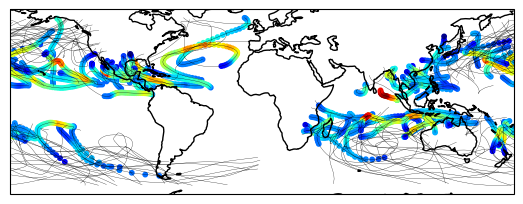

In [24]:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)
lon = ds['longitude'].values
lat = ds['latitude'].values
mwspd = ds['Mwspd'].values
plt.plot(lon,lat,'k-',transform=ccrs.PlateCarree(),linewidth=0.2)
plt.scatter(lon.ravel(),lat.ravel(),s=10,c=mwspd[1,:,:].ravel(),transform=ccrs.PlateCarree(), cmap='jet')
#plt.colorbar()

*   Intensity evoluation of a track #9



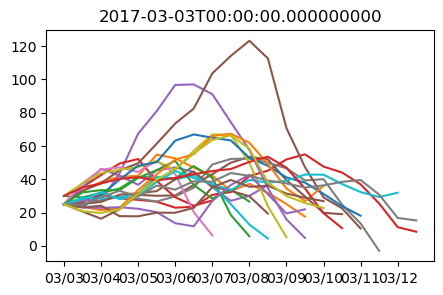

In [25]:
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(5,3))
time_1d = ds.time.values.reshape(-1)
df_chaz_t = pd.to_datetime(time_1d,unit='D',origin=pd.Timestamp('1950-01-01'))
origional_shape = ds.time.values.shape
df_chaz_t = df_chaz_t.to_numpy().reshape(origional_shape)
plt.plot(df_chaz_t[:,22],mwspd[:,:,22].T)
plt.title(df_chaz_t[0,22])
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)



*   Lifetime Maximum Intensity distribution

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_15309/2662542693.py:1: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(ds['Mwspd'].values,axis=1)


Text(0.5, 1.0, 'LMI')

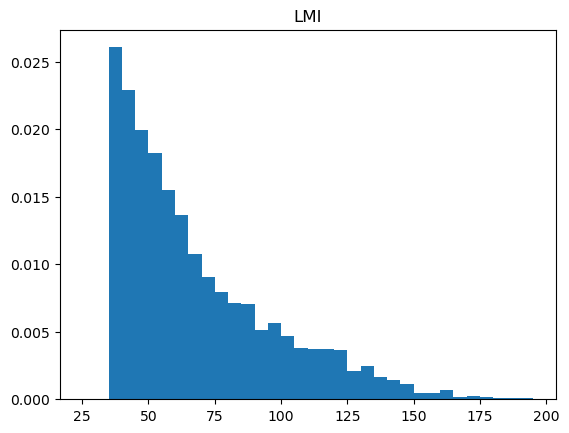

In [26]:
vmax = np.nanmax(ds['Mwspd'].values,axis=1)
plt.hist(vmax.flatten(), bins=np.arange(25,200,5), density=True, )
plt.title('LMI')